# Scrapping

In [12]:
import requests as req
from bs4 import BeautifulSoup as bs
import pandas as pd

# Define User Agent biar ga keblokir
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

In [13]:
url = "https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population"
# Mengambil konten halaman
response = req.get(url, headers=headers)
response.raise_for_status()

# Memastikan request berhasil
if response.status_code == 200:
    print("Berhasil")
else:
    print(f"Gagal. Status: {response.status_code}")

Berhasil


In [14]:
import duckdb as ddb
con = ddb.connect("world_populations")

In [15]:
soup = bs(response.content, 'html.parser')

In [16]:
main_content = soup.find('div', id='mw-content-text')

In [17]:
table = main_content.find('table', class_='wikitable')

In [23]:
header = []
rows = []

In [24]:
for th in table.find_all('th'):
        header.append(th.text.strip())

In [25]:
for tr in table.find_all('tr'):
    cleansing = []
    for td in tr.find_all('td'):
        cleansing.append(td.text.strip())
    if len(cleansing) > 0:
        rows.append(cleansing)

In [33]:
tables = pd.DataFrame(rows, columns=header)
tables

,Location,Population,% ofworld,Date,Source (official or fromthe United Nations),Notes
0,World,"8,232,000,000",100%,13 Jun 2025,UN projection[1][3],
1,India,"1,417,492,000",17.3%,1 Jul 2025,Official projection[4],[b]
2,China,"1,408,280,000",17.2%,31 Dec 2024,Official estimate[5],[c]
3,United States,"340,110,988",4.1%,1 Jul 2024,Official estimate[6],[d]
4,Indonesia,"284,438,782",3.5%,30 Jun 2025,National annual projection[7],
...,...,...,...,...,...,...
235,Niue (New Zealand),"1,681",0%,11 Nov 2022,2022 Census[252],
236,Tokelau (New Zealand),"1,647",0%,1 Jan 2019,2019 Census[253],
237,Vatican City,882,0%,31 Dec 2024,Official figure[254],[ah]
238,Cocos (Keeling) Islands (Australia),593,0%,30 Jun 2020,2021 Census[255],


# Cleaning

In [43]:
# Filter 5 kolom pertama
df = tables.iloc[:, [0, 1, 2, 3, 4]]
# Rename kolom agar lebih mudah dibaca
df.columns = ['Location', 'Population', 'Percentage', 'Date', 'Source']

In [42]:
df.head(5)

,Location,Population,Percentage,Date,Source
0,World,"8,232,000,000",100%,13 Jun 2025,UN projection[1][3]
1,India,"1,417,492,000",17.3%,1 Jul 2025,Official projection[4]
2,China,"1,408,280,000",17.2%,31 Dec 2024,Official estimate[5]
3,United States,"340,110,988",4.1%,1 Jul 2024,Official estimate[6]
4,Indonesia,"284,438,782",3.5%,30 Jun 2025,National annual projection[7]


In [45]:
# Hapus baris pertama/World karena tidak digunakan untuk analisis
df = df.drop(index=0)

In [46]:
# Cek tipe
df.dtypes

,0
Location,object
Population,object
Percentage,object
Date,object
Source,object


### Ubah semua tipe data yang tidak sesuai

In [47]:
# Ubah tipe data kolom Population ke int
df['Population'] = df['Population'].str.replace(',', '', regex=False).astype(int)

# Ubah tipe data kolom Date ke datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

### Bersihin persen nilai kolom '% of the world & ubah tipe data jadi float'

In [49]:
# Hapus persen nilai kolom '% of the world & ubah tipe data jadi float'

df['Percentage'] = (
    df['Percentage']
    .str.replace('%', '', regex=False)
    .astype(float)
)

In [40]:
# Cek hasil
df.head(3)

,Location,Population,% ofworld,Date,Source (official or fromthe United Nations)
1,India,"1,417,492,000",17.3,1 Jul 2025,Official projection[4]
2,China,"1,408,280,000",17.2,31 Dec 2024,Official estimate[5]
3,United States,"340,110,988",4.1,1 Jul 2024,Official estimate[6]


### Bersihin penulisan sitasi di kolom Source

In [51]:
# Hapus nomor sitasi di kolom 'Source ...'
df['Source'] = df['Source'].str.replace(r'\[.*\]', '', regex=True).str.strip()

In [52]:
df.head(3)

,Location,Population,Percentage,Date,Source
1,India,1417492000,17.3,2025-07-01,Official projection
2,China,1408280000,17.2,2024-12-31,Official estimate
3,United States,340110988,4.1,2024-07-01,Official estimate


In [53]:
# Hasil data final
df

,Location,Population,Percentage,Date,Source
1,India,1417492000,17.3,2025-07-01,Official projection
2,China,1408280000,17.2,2024-12-31,Official estimate
3,United States,340110988,4.1,2024-07-01,Official estimate
4,Indonesia,284438782,3.5,2025-06-30,National annual projection
5,Pakistan,241499431,2.9,2023-03-01,2023 census result
...,...,...,...,...,...
235,Niue (New Zealand),1681,0.0,2022-11-11,2022 Census
236,Tokelau (New Zealand),1647,0.0,2019-01-01,2019 Census
237,Vatican City,882,0.0,2024-12-31,Official figure
238,Cocos (Keeling) Islands (Australia),593,0.0,2020-06-30,2021 Census


# Export to Excel

In [54]:
from google.colab import files
df.to_excel('world_data_populations.xlsx', index=False, sheet_name='World Populations Data')
df_excel = 'world_data_populations.xlsx'
# Download file excel
# files.download(df_excel)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Analysis

In [55]:
avg_population = df['Population'].mean()
print(f"Rata-rata populasi seluruh dunia = {avg_population:.2f}")

Rata-rata populasi seluruh dunia = 33554601.64


In [56]:
min_population = df['Population'].min()
print(f"Populasi terendah  = {min_population}")

Populasi terendah  = 35


In [57]:
top5_country = df.iloc[:5, :2]
print("Top 5 Negara dengan Populasi Terbanyak")
top5_country

Top 5 Negara dengan Populasi Terbanyak


,Location,Population
1,India,1417492000
2,China,1408280000
3,United States,340110988
4,Indonesia,284438782
5,Pakistan,241499431


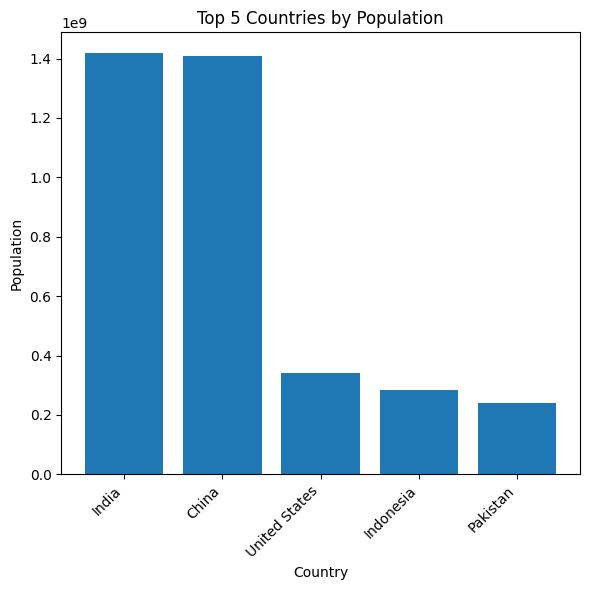

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.bar(top5_country['Location'], top5_country['Population'])
plt.xlabel('Country')
plt.ylabel('Population')
plt.title('Top 5 Countries by Population')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

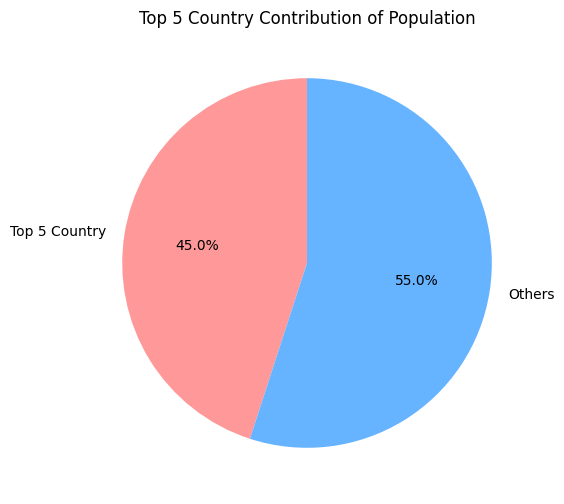

In [63]:
df_top5 = df.head(5)

# Hitung persentase Top 5
top5_percentage = df_top5['Percentage'].sum()

# Hitung persentase Sisa Dunia
others_percentage = 100.0 - top5_percentage

# D. Siapkan data untuk chart (hanya 2 kategori)
sizes = [top5_percentage, others_percentage]
labels = ['Top 5 Country', 'Others']

plt.figure(figsize=(6, 6))
plt.pie(
    sizes
    labels=labels
    autopct='%1.1f%%'
    startangle=90
    colors=['#ff9999','#66b3ff']
)
plt.title('Top 5 Country Contribution of Population')
plt.show()

Insight:
Dari grafik bisa dilihat bahwa 5 Negara dengan populasi terbanyak memiliki total 45% populasi dari keseluruhan populasi di dunia. Ini menunjukkan bahwa hampir setengah populasi umat manusia tinggal di 5 negara teratas ini saja

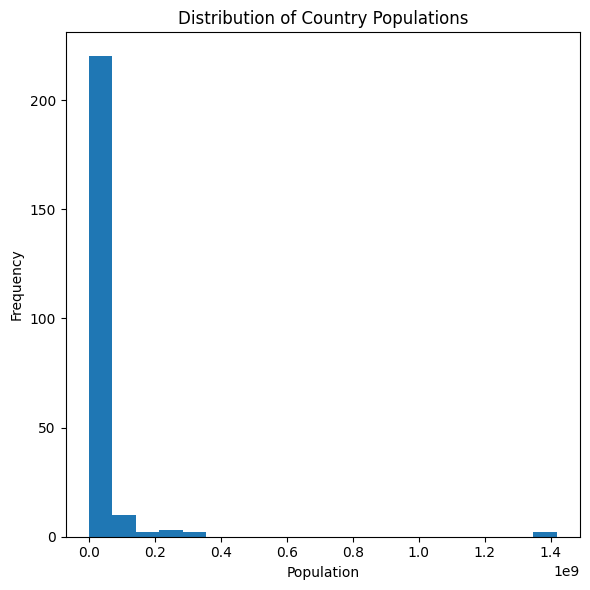

In [65]:
plt.figure(figsize=(6, 6))
plt.hist(df['Population'], bins=20)
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.title('Distribution of Country Populations')
plt.tight_layout()
plt.show()

Mayoritas negara di dunia memiliki populasi yang relatif kecil. Frekuensi lebih dari 200 menunjukkan ada lebih dari 200 negara dengan populasi kurang lebih di bawah 100 juta orang.